In [3]:
import pandas as pd
from pandas.io.json import loads, json_normalize

# challenge specifies to load fullVisitorId as a string to guarantee uniqueness
id_to_str = {'fullVisitorId': str}

#train = pd.read_csv('./all/train.csv', dtype=id_to_str)
#test  = pd.read_csv('./all/test.csv', dtype=id_to_str)

In [4]:
# Referenced the following link to get the json to parse correctly:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def parse_json_cols(df):
    for col in ['device', 'geoNetwork', 'totals', 'trafficSource']:
        # load the json and separate
        df_json = json_normalize(df[col].apply(loads), sep='/')
        df_json.columns = [(col + '/' + c) for c in df_json.columns]
        df.drop(columns=col, inplace=True)
        df = pd.concat([df, df_json], axis=1)
    return df

#
train = parse_json_cols(train)
test  = parse_json_cols(test)

---
# Examine data

### Dates are not parsed and visitStartTime is in POSIX time
    * visitStartTime makes Date redundant (more information encoded)
    * need to get continuous time data (hour, minute)

In [5]:
from datetime import datetime

def parse_dates(df):
    df['visitStartTime'] = df['visitStartTime'].apply(lambda time: datetime.fromtimestamp(time))
    df['year']  = df['visitStartTime'].dt.year
    df['month'] = df['visitStartTime'].dt.month
    df['day']   = df['visitStartTime'].dt.day
    df['hour']  = df['visitStartTime'].dt.hour + (df['visitStartTime'].dt.minute/60)
    df.drop(columns=['date', 'visitStartTime'], inplace=True)

    return df

#
train = parse_dates(train)
test  = parse_dates(test)

### Several columns have NaN values
* Every value in totals should have a lower bound of 0.
* Will fill remainder with most frequent value

In [6]:
nan_series = train.isna().any()
nan_true   = nan_series[nan_series == True]
nan_true

totals/bounces                                  True
totals/newVisits                                True
totals/pageviews                                True
totals/transactionRevenue                       True
trafficSource/adContent                         True
trafficSource/adwordsClickInfo/adNetworkType    True
trafficSource/adwordsClickInfo/gclId            True
trafficSource/adwordsClickInfo/isVideoAd        True
trafficSource/adwordsClickInfo/page             True
trafficSource/adwordsClickInfo/slot             True
trafficSource/campaignCode                      True
trafficSource/isTrueDirect                      True
trafficSource/keyword                           True
trafficSource/referralPath                      True
dtype: bool

In [7]:
def clean_nans(df):
    totals_cols = list(filter(lambda c : c.startswith('totals'), df.columns))
    for i in totals_cols:
        df[i] = df[i].astype(float)
        df[i].fillna(0, inplace=True)
   
    nan_series = df.isna().any()
    nan_true   = nan_series[nan_series == True]
    remaining_nan_cols = list(set(nan_true.index) - set(totals_cols))
    
    for i in remaining_nan_cols:
        # fill with most frequent value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)
        
    return df

#
train = clean_nans(train)
test  = clean_nans(test)

### Several columns have 1 unique value
    * Provide no information, so will drop

In [8]:
for col in train:
    if len(train[col].unique()) == 1:
        print(col)

socialEngagementType
device/browserSize
device/browserVersion
device/flashVersion
device/language
device/mobileDeviceBranding
device/mobileDeviceInfo
device/mobileDeviceMarketingName
device/mobileDeviceModel
device/mobileInputSelector
device/operatingSystemVersion
device/screenColors
device/screenResolution
geoNetwork/cityId
geoNetwork/latitude
geoNetwork/longitude
geoNetwork/networkLocation
totals/visits
trafficSource/adwordsClickInfo/criteriaParameters
trafficSource/adwordsClickInfo/isVideoAd
trafficSource/campaignCode
trafficSource/isTrueDirect


In [9]:
def drop_single_val_cols(df):
    for col in df:
        if len(df[col].unique()) == 1:
            df.drop(columns=[col], inplace=True)
    return df

#
train = drop_single_val_cols(train)
test  = drop_single_val_cols(test)

# A lot of data is categorical
* Thinks like referal links, locations, and keywords are categorical and need to be represented as such
    * Create features depending on importance of certain values
    * Dropping certain columns with seemingly redundant or unnecessary data
    * Will use one-hot encoding for the rest, bucketing less frequent values

In [10]:
# keep an unencoded copy for visualization
unencoded_train = train.copy(deep=True)

categories = list(train.select_dtypes(include='object').columns)
categories.remove('fullVisitorId')
categories

['channelGrouping',
 'sessionId',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/networkDomain',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adContent',
 'trafficSource/adwordsClickInfo/adNetworkType',
 'trafficSource/adwordsClickInfo/gclId',
 'trafficSource/adwordsClickInfo/page',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/campaign',
 'trafficSource/keyword',
 'trafficSource/medium',
 'trafficSource/referralPath',
 'trafficSource/source']

## Feature: Contains "Google"
* For the following columns, many rows with non-zero revenue have a string containing some variation of "Google"
    * trafficSource/keyword
    * trafficSource/adContent
    * trafficSource/adwordsClickInfo/adNetworkType
    * trafficSource/source

In [11]:
import re

google_cols = ['trafficSource/keyword', 
               'trafficSource/adContent', 
               'trafficSource/adwordsClickInfo/adNetworkType', 
               'trafficSource/source']

def contains_google(df):
    for i in google_cols:
        if i not in df.columns:
            continue
        df['{0}/contains_google'.format(i)] =\
        df[i].apply(lambda x: bool(re.search('google', x, re.IGNORECASE)))
        df.drop(columns=[i], inplace=True)
    return df

#
train = contains_google(train)
test  = contains_google(test)

---
* Removing some columns for now:

In [12]:
to_drop = ['sessionId',
           'trafficSource/adwordsClickInfo/gclId',
           'trafficSource/adwordsClickInfo/page',
           'trafficSource/campaign',
           'trafficSource/referralPath',
           'geoNetwork/networkDomain']

def drop_columns(df):
    for c in to_drop:
        if c in df.columns:
            df.drop(columns=[c], inplace=True)
    return df
        
#
train = drop_columns(train)
test  = drop_columns(test)

In [13]:
categories = list(train.select_dtypes(include='object').columns)
categories.remove('fullVisitorId')
categories

['channelGrouping',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/medium']

In [14]:
def one_hot(df):
    for i in categories:
        if i not in df.columns:
            continue
        value_counts = df[i].value_counts()
        if len(value_counts) > 4:
            bound = value_counts[3]
            bucket = value_counts[value_counts <= bound].index
            if len(bucket) >= 1:
                df[i] = df[i].replace(bucket, 'bucket')
    df = pd.get_dummies(df, columns=categories)
    return df

#
train = one_hot(train)
test  = one_hot(test)

---
* Target specified as ln(total transaction revenue + 1)
    * Need to convert transactionRevenue column to accomodate

In [15]:
from numpy import log1p

# to make the line more readable
i = 'totals/transactionRevenue'

train[i] = train[i].apply(lambda revenue: log1p(revenue))
unencoded_train[i] = unencoded_train[i].apply(lambda revenue: log1p(revenue))

# External Dataset: OECD Consumer Confidence Index

OECD - Total from Jan 2016 - Sep 2018

https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart


* OECD (2018), Consumer confidence index (CCI) (indicator). doi: 10.1787/46434d78-en (Accessed on 11 October 2018)

In [16]:
def add_cci(df):
    cci = pd.read_csv('./all/oecd_total_cci.csv', index_col=0)
    cci_dict = cci.to_dict()['Value']
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    
    df['cci'] = df['year-month'].map(cci_dict)
    df['cci'].fillna(df['cci'].median(), inplace=True)
    
    df.drop(columns=['year-month'], inplace=True)
    return df

train = add_cci(train)
test  = add_cci(test)
unencoded_train = add_cci(unencoded_train)

#### Remove differences in columns from training set
* Only column difference should be totals/transactionRevenue

In [21]:
train_columns = train.columns
test_columns  = test.columns
in_both = list(set(train_columns) & set(test_columns))

train_columns = in_both
test_columns  = in_both[:]
train_columns.append('totals/transactionRevenue')

train = train[train_columns]
test  = test[test_columns]

#### Save Preprocessed DataFrames

In [22]:
#train.to_csv('./all/p_train.csv', index=False)
#test.to_csv('./all/p_test.csv', index=False)
#unencoded_train.to_csv('./all/unencoded_train.csv', index=False)

---
---
---
# Load Preprocessed DataFrames

In [112]:
import pandas as pd

id_to_str = {'fullVisitorId': str}

train = pd.read_csv('./all/p_train.csv', dtype=id_to_str)
test  = pd.read_csv('./all/p_test.csv', dtype=id_to_str)
unencoded_train = pd.read_csv('./all/unencoded_train.csv', dtype=id_to_str)

---
# Visualize

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

%matplotlib inline

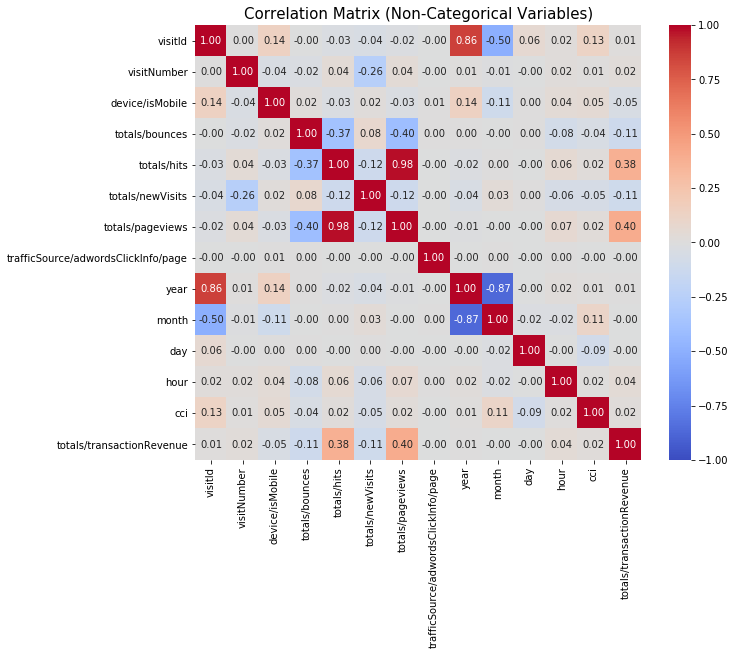

In [117]:
no_cats = unencoded_train.select_dtypes(exclude='object')

i = 'totals/transactionRevenue'
columns = list(no_cats.columns)
columns.remove(i); columns.append(i)

no_cats = no_cats[columns]

no_cats_corr = no_cats.corr()
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix (Non-Categorical Variables)', fontsize=15)
sns.heatmap(no_cats_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1, 
            cbar_kws=dict(ticks=list(np.arange(-1.0, 1.1, 0.25))), fmt='.2f')
plt.show()

In [118]:
len(train.columns)

61

In [6]:
no_cats.corr()['totals/transactionRevenue'].sort_values(ascending=False)

totals/transactionRevenue              1.000000
totals/pageviews                       0.400732
totals/hits                            0.378804
hour                                   0.040587
visitNumber                            0.023666
cci                                    0.016590
visitId                                0.010491
year                                   0.007604
trafficSource/adwordsClickInfo/page   -0.000815
day                                   -0.000860
month                                 -0.002693
device/isMobile                       -0.046071
totals/newVisits                      -0.108003
totals/bounces                        -0.113049
Name: totals/transactionRevenue, dtype: float64

---
### The majority of paying customers will view the site under 30 times.

C:\Users\milto\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


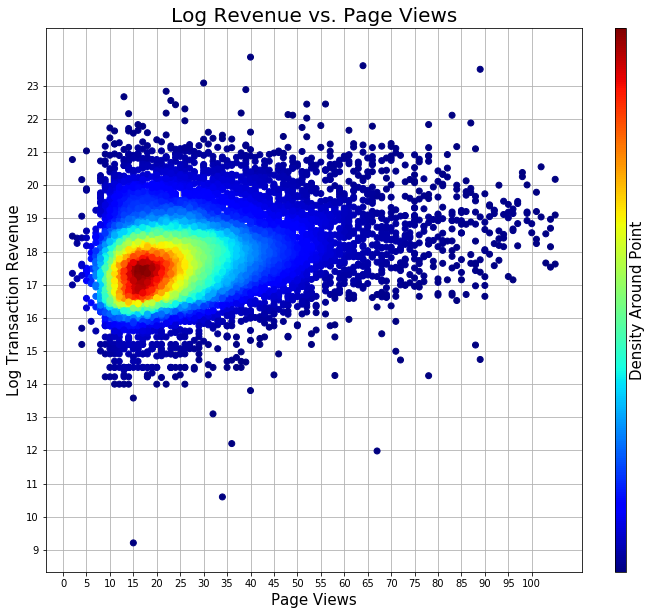

In [202]:
pv_tr = train[train['totals/transactionRevenue'] > 0]
p_99 = np.percentile(pv_tr['totals/pageviews'].sort_values(), 99)
pv_tr = pv_tr[pv_tr['totals/pageviews'] < p_99]

x_values = pv_tr['totals/pageviews']
y_values = pv_tr['totals/transactionRevenue']

xy = np.vstack([x_values, y_values])
density = gaussian_kde(xy)(xy)

plt.figure(figsize=(12, 10))
plt.title('Log Revenue vs. Page Views', fontsize=20)
plt.xticks(np.arange(0, x_values.max(), step=5))
plt.yticks(np.arange(0, y_values.max(), step=1))
plt.xlabel('Page Views', fontsize=15)
plt.ylabel('Log Transaction Revenue', fontsize=15)
plt.scatter(x_values, y_values, alpha=1, c=density, cmap='jet')
plt.colorbar(ticks=[], aspect=50).set_label('Density Around Point', fontsize=15)
plt.grid(True)
plt.axes().set_axisbelow(True)
plt.show()

---
### Referalls bring in the most page views and the most revenue

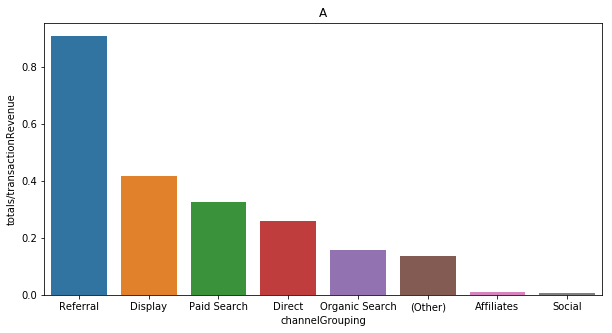

In [6]:
browser_rev = unencoded_train[['totals/transactionRevenue', 'channelGrouping']]
#browser_rev = browser_rev[browser_rev['totals/transactionRevenue'] > 0]
browser_rev = browser_rev.groupby('channelGrouping').mean()
browser_rev = browser_rev.sort_values(by='totals/transactionRevenue', ascending=False)
x = browser_rev.index
y = browser_rev['totals/transactionRevenue']
plt.figure(figsize=(10, 5))
sns.barplot(x, y).set_title('A')
plt.show()

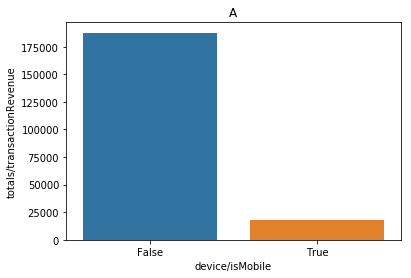

In [7]:
mobile_revenue = train[['totals/transactionRevenue', 'device/isMobile']]
mobile_revenue = mobile_revenue.groupby('device/isMobile').sum()
x = mobile_revenue.index
y = mobile_revenue['totals/transactionRevenue']
sns.barplot(x, y).set_title('A')
plt.show()

In [8]:
unencoded_train['month'].value_counts()

11    113935
10     97286
12     79458
8      77307
7      71782
9      71103
3      69924
4      67148
5      65336
1      64634
6      63565
2      62175
Name: month, dtype: int64

In [9]:
unencoded_train['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64



https://support.google.com/analytics/answer/3297892?hl=en&ref_topic=6010089

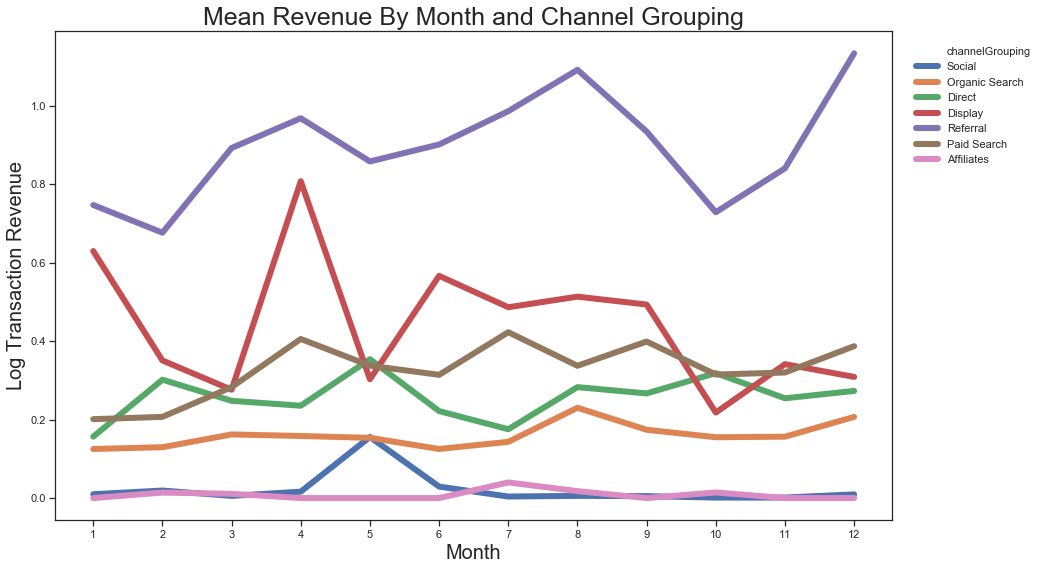

In [204]:
channels = unencoded_train[['channelGrouping', 'totals/transactionRevenue', 'month']]
channels = channels[channels['channelGrouping'] != '(Other)']

plt.figure(figsize=(15,9))
plt.xticks(np.arange(0, 12+1, step=1))
channels = channels.sort_values(by='month')

sns.set(style="ticks", rc={"lines.linewidth": 6})
sns.lineplot('month', 'totals/transactionRevenue', data=channels, err_style=None, estimator='mean', hue='channelGrouping')
plt.title('Mean Revenue By Month and Channel Grouping', fontsize=25)
plt.xlabel('Month', fontsize=20); 
plt.ylabel('Log Transaction Revenue', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=1, frameon=False)
plt.show()

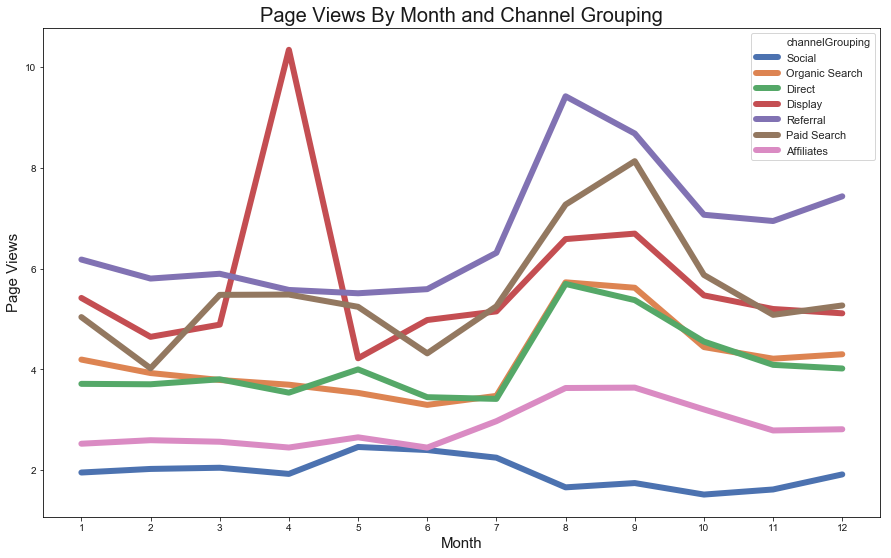

In [203]:
channels = unencoded_train[['channelGrouping', 'totals/pageviews', 'month']]
channels = channels[channels['channelGrouping'] != '(Other)']

plt.figure(figsize=(15,9))
plt.xticks(np.arange(0, 12+1, step=1))
channels = channels.sort_values(by='month')

sns.set(style="ticks", rc={"lines.linewidth": 6})
sns.lineplot('month', 'totals/pageviews', data=channels, err_style=None,  hue='channelGrouping')
plt.title('Page Views By Month and Channel Grouping', fontsize=20)
plt.xlabel('Month', fontsize=15); 
plt.ylabel('Page Views', fontsize=15)
plt.show()

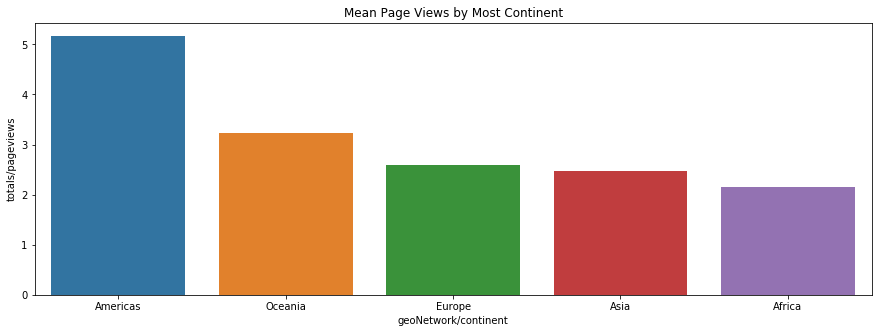

In [35]:
c_pv_df = unencoded_train[unencoded_train['geoNetwork/continent'] != '(not set)']
c_pv_df = c_pv_df.groupby('geoNetwork/continent').mean()
c_pv_df = c_pv_df.sort_values(by='totals/pageviews', ascending=False)
x = c_pv_df.index
y = c_pv_df['totals/pageviews']
plt.figure(figsize=(15,5))
sns.barplot(x, y).set_title('Mean Page Views by Most Continent')
plt.show()

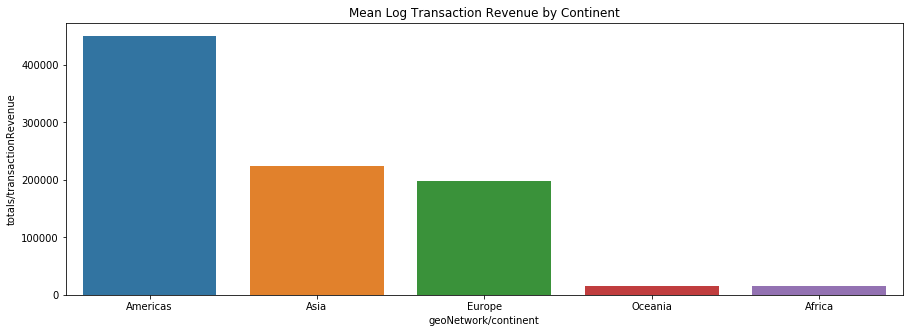

In [41]:
c_tr_df = unencoded_train[unencoded_train['geoNetwork/continent'] != '(not set)']
c_tr_df = c_tr_df.groupby('geoNetwork/continent').count()
c_tr_df = c_tr_df.sort_values(by='totals/transactionRevenue', ascending=False)
x = c_tr_df.index
y = c_tr_df['totals/transactionRevenue']
plt.figure(figsize=(15,5))
sns.barplot(x, y).set_title('Mean Log Transaction Revenue by Continent')
plt.show()

In [5]:
vc = unencoded_train['geoNetwork/continent'].value_counts()
vc_i = vc.index
vc_c = list(vc)

vc_dict = dict(list(zip(vc_i, vc_c)))
vc_dict

{'Americas': 450377,
 'Asia': 223698,
 'Europe': 198311,
 'Oceania': 15054,
 'Africa': 14745,
 '(not set)': 1468}

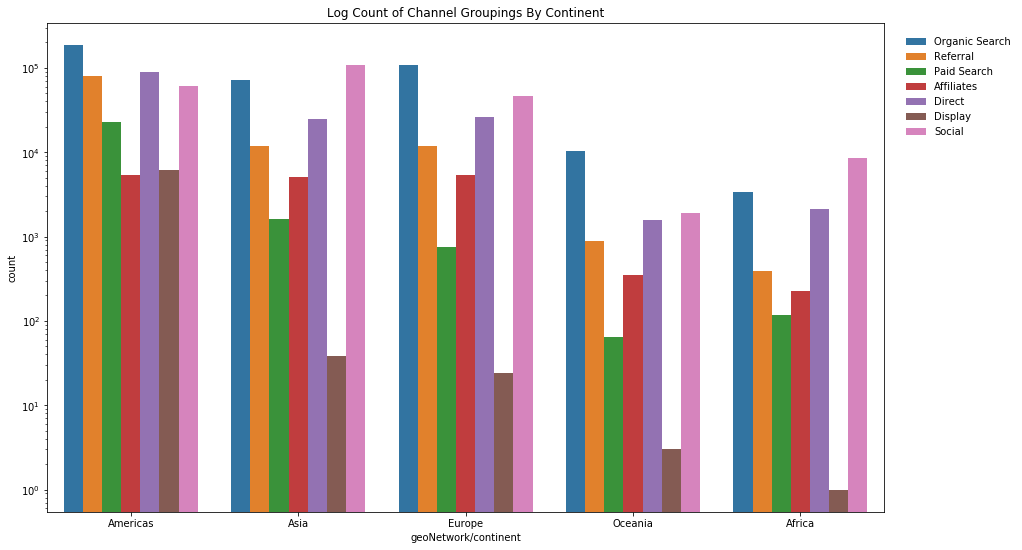

In [48]:
c_cg_df = unencoded_train[['geoNetwork/continent', 'channelGrouping', 'totals/transactionRevenue']]

c_cg_df = c_cg_df[c_cg_df['channelGrouping'] != '(Other)']
c_cg_df = c_cg_df[c_cg_df['geoNetwork/continent'] != '(not set)']

order = c_cg_df['geoNetwork/continent'].value_counts().index

plt.figure(figsize=(15,9))
sns.countplot(c_cg_df['geoNetwork/continent'], order=order, hue=c_cg_df['channelGrouping']).set_yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=1, frameon=False)
plt.title('Log Count of Channel Groupings By Continent')
plt.show()

---
# Train models

In [66]:
def get_tt_split(df):
    X = df.drop(columns=['totals/transactionRevenue', 'fullVisitorId'])
    y = df['totals/transactionRevenue']
    
    return train_test_split(X, y, test_size=0.1, random_state=3)

### Linear Regression

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_lr(df, details=True):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    model = LinearRegression()
    if details:
        print('Training model: {0}...\n'.format('lr'))
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    if details:
        print('=====')
        print('RMSE:', rmse)
        print('=====\n\n==========')
        print('INTERCEPT:', model.intercept_)
        print('==========\n\n==========================')
        print('COEFFICIENTS (decreasing):')
        print('==========================')
        coefficients = list(zip(X_test.columns, model.coef_))
        coefficients.sort(key = lambda c: c[1])
        for i in coefficients[::-1]:
            print('{0}:\n\t{1}\n'.format(i[0], i[1]))
    
    
    return model, rmse

In [111]:
%%time
lr_model, score = train_lr(train)

Training model: lr...

=====
RMSE: 1.8091771277220583
=====

INTERCEPT: -5777.532800172452

COEFFICIENTS (decreasing):
year:
	2.9235173879427023

totals/bounces:
	0.351940581143764

totals/pageviews:
	0.2628776964990247

month:
	0.2493175393420882

geoNetwork/country_United States:
	0.20703337990970974

trafficSource/medium_referral:
	0.1924674576114161

geoNetwork/metro_bucket:
	0.12995820903470418

trafficSource/adwordsClickInfo/adNetworkType/contains_google:
	0.11940524442148336

device/operatingSystem_Macintosh:
	0.09898160951037618

cci:
	0.09117718217702578

device/deviceCategory_desktop:
	0.0682755177028502

channelGrouping_bucket:
	0.0651746358548026

geoNetwork/city_bucket:
	0.054760077330343174

trafficSource/source/contains_google:
	0.05076248744258724

trafficSource/adwordsClickInfo/slot_RHS:
	0.03689108690911029

geoNetwork/continent_bucket:
	0.032897416683057554

device/browser_bucket:
	0.029479240278513702

trafficSource/keyword/contains_google:
	0.02656662932796332

geo

In [62]:
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_xgb(df, details=True):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    if details:
        print('Training model: {0}...'.format('xgb'))
    model = xgb.train({'eta':0.1}, DMatrix(X_train, y_train))
    test_predictions = model.predict(DMatrix(X_test))
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    if details:
        print('=====')
        print('RMSE:', rmse)
    return model, rmse

In [63]:
%%time
xgb_model, score = train_xgb(train)

Training model: xgb...
=====
RMSE: 1.731267722719313
Wall time: 13.7 s


---
# Permutation Test

In [113]:
all_corrs = train.corr()['totals/transactionRevenue'].sort_values(ascending=False)
print('HIGHEST POSITIVE CORRELATIONS:\n')
print(all_corrs[1:6])
print('-----------------------------\n')
print('HIGHEST MAGNITUTUDE NEGATIVE CORRELATIONS:\n')
print(all_corrs.tail())

to_test = list(all_corrs.index[1:6]) + list(all_corrs.tail().index)

HIGHEST POSITIVE CORRELATIONS:

totals/pageviews                            0.400732
totals/hits                                 0.378804
geoNetwork/country_United States            0.126414
geoNetwork/subContinent_Northern America    0.122415
geoNetwork/continent_Americas               0.109113
Name: totals/transactionRevenue, dtype: float64
-----------------------------

HIGHEST MAGNITUTUDE NEGATIVE CORRELATIONS:

channelGrouping_Social           -0.063181
geoNetwork/subContinent_bucket   -0.089012
geoNetwork/country_bucket        -0.102342
totals/newVisits                 -0.108003
totals/bounces                   -0.113049
Name: totals/transactionRevenue, dtype: float64


In [114]:
from numpy.random import permutation

def permutation_test(df, permutations):
    for i in to_test:
        original_column = df[i].copy(deep=True)
        _, original_score = train_lr(df, details=False)
        
        # count of permutations with better score (lower rmse)
        count = 0
        
        for j in range(0, permutations):
            df[i] = permutation(df[i])
            _, score = train_lr(df, details=False)
            if score < original_score:
                count += 1
            df[i] = original_column
        print('{0} permutation test results:'.format(i))
        print('{0}/{1} = {2}'.format(count, permutations, (count*1.0)/permutations))
        print('---------')

In [115]:
permutation_test(train, permutations=100)

totals/pageviews permutation test results:
0/100 = 0.0
---------
totals/hits permutation test results:
0/100 = 0.0
---------
geoNetwork/country_United States permutation test results:
37/100 = 0.37
---------
geoNetwork/subContinent_Northern America permutation test results:
0/100 = 0.0
---------
geoNetwork/continent_Americas permutation test results:
51/100 = 0.51
---------
channelGrouping_Social permutation test results:
46/100 = 0.46
---------
geoNetwork/subContinent_bucket permutation test results:
0/100 = 0.0
---------
geoNetwork/country_bucket permutation test results:
42/100 = 0.42
---------
totals/newVisits permutation test results:
0/100 = 0.0
---------
totals/bounces permutation test results:
0/100 = 0.0
---------


---
# Specify model

In [21]:
selected_model = 'xgb'

# Create Submission

In [22]:
X_test = test.drop(columns=['fullVisitorId'])

if selected_model == 'lr':
    model, score = train_lr(train)
elif selected_model == 'xgb':
    model, score = train_xgb(train)
    X_test = DMatrix(X_test)

real_predictions, score = model.predict(X_test)
real_predictions = clip(real_predictions, a_min=0, a_max=None)

real_df = test['fullVisitorId'].to_frame()
real_df['PredictedLogRevenue'] = real_predictions
real_df['fullVisitorId'] = real_df['fullVisitorId'].astype('str')
real_df = real_df.groupby('fullVisitorId').sum()
real_df.to_csv('submission.csv')

Training model: xgb...
=====
RMSE: 1.6011276735377202
